# Unique dog feature extraction
The outcome of this notebook will include research and analysis of data preperation <br/>
The feature I wish to isolate from sample dog images include
* Tails
* Ears
* Legs
* Hair Type
* Colour
* Patterns

# Data Source
For the sake of this data preparation section, I shall use photo data sourced from [American Kenel Club](https://www.akc.org/dog-breeds) as they provied well documented characteristics of dogs, as well as front,side, and isometric profile pictures of all the dogs on their site.

# Outcome
The outcome from these will be a binary answer, can these features be easily extracted from set of dog breeds to a high degree of accuracy. These answers will play into the App UX design. If a feature fails to meet the following requirements, it may be that the user will be asked to provide these details. <br/>
Such a thing would like to be avoided, as the idea of the application is that the whole processes of creating a model of the dog is automated.
* Can it be extracted ?
* How easy is it to extract (0 - 10)
* How accurate is the representaion of the feature compared to original feature image (0- 10) 
* How accuratly is the model when tested on various breeds

## Colour Extraction
What follows is an attempt to extract the most dominant colours from an image of a dog after canny edge performed on the image. A blue mask is applied to the image around the captured dog.

In [2]:
# Boiler plate imports 
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import image as image
import easygui
from sklearn.cluster import KMeans
from collections import Counter
import extcolors
import webcolors

In [3]:
# Loading in the imgage
fileLocation = "../Single Dogs/Bernese Mountain Dog Side Face.jpg"
berneseMountainDog = image.imread("../Single Dogs/Bernese Mountain Dog Side.jpg")

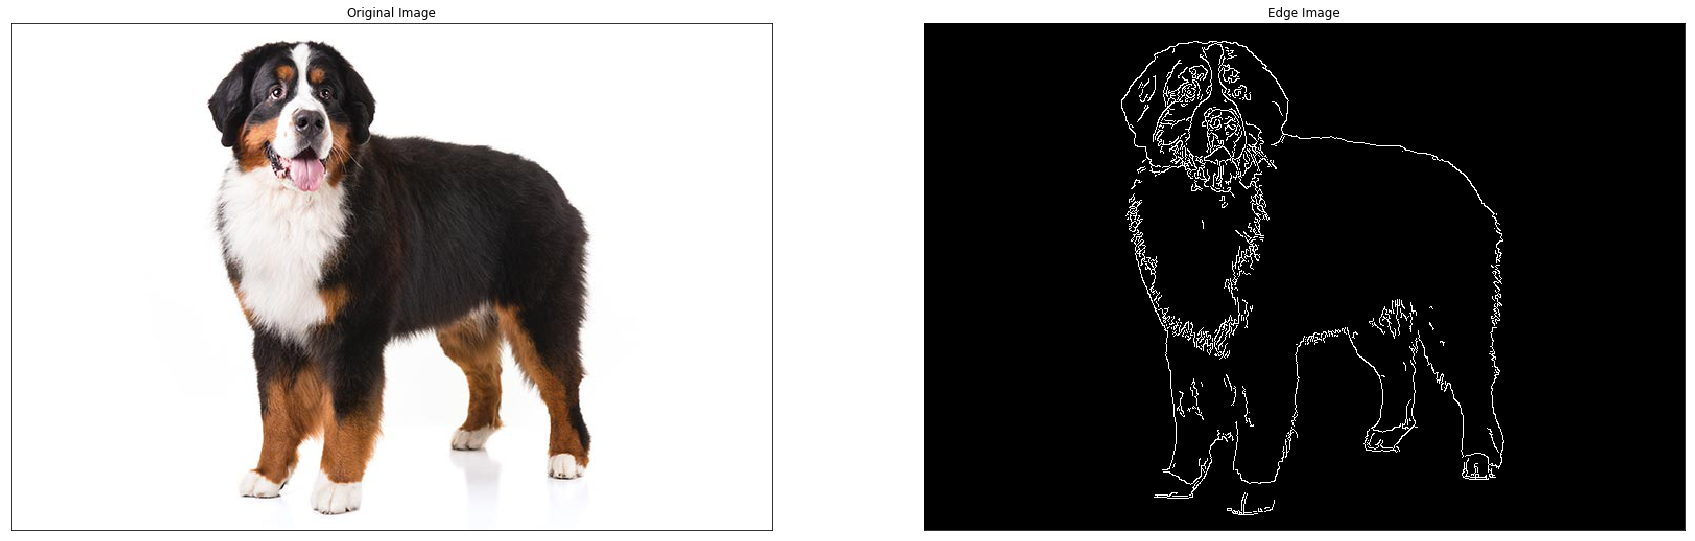

In [4]:
# https://docs.opencv.org/3.1.0/da/d22/tutorial_py_canny.html
edges = cv2.Canny(cv2.cvtColor(berneseMountainDog,cv2.COLOR_BGR2GRAY),100,200)
plt.figure(figsize=(30,30))
plt.subplot(121),plt.imshow(berneseMountainDog,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

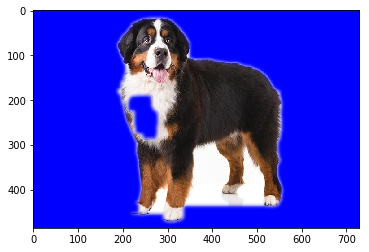

In [64]:
#== Parameters =======================================================================
BLUR = 21
CANNY_THRESH_1 = 10
CANNY_THRESH_2 = 200
MASK_DILATE_ITER = 10
MASK_ERODE_ITER = 10
MASK_COLOR = (0.0,0.0,1.0) # In BGR format


#== Processing =======================================================================

#-- Read image -----------------------------------------------------------------------
img = berneseMountainDog
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#-- Edge detection -------------------------------------------------------------------
edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
edges = cv2.dilate(edges, None)
edges = cv2.erode(edges, None)

#-- Find contours in edges, sort by area ---------------------------------------------
contour_info = []
_, contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

for c in contours:
    contour_info.append((
        c,
        cv2.isContourConvex(c),
        cv2.contourArea(c),
    ))
contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
max_contour = contour_info[0]

#-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
# Mask is black, polygon is white
mask = np.zeros(edges.shape)
cv2.fillConvexPoly(mask, max_contour[0], (255))

#-- Smooth mask, then blur it --------------------------------------------------------
mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

#-- Blend masked img into MASK_COLOR background --------------------------------------
mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
img         = img.astype('float32') / 255.0                 #  for easy blending

masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit 

plt.imshow(masked)                                   # Display
plt.imsave("masked.jpg",masked)


In [57]:


def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)

In [58]:
get_dominant_color(berneseMountainDog)

[253.8788647421895, 253.49428628685996, 253.28512620083558]

In [72]:
colors, pixel_count = extcolors.extract("masked.jpg")

In [ ]:
colors

In [73]:
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return closest_name

requested_colour = colors[5][0]
closest_name = get_colour_name(requested_colour)

print("Actual colour name: closest colour name:", closest_name)

Actual colour name: closest colour name: royalblue


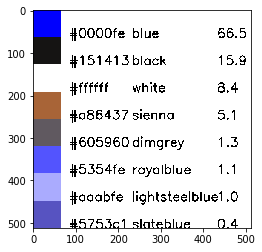

In [74]:
sizeOfColours = len(colors)
squareIterations = 64

topX = topY = 0
bottomX = bottomY = squareIterations
count = 0

hexColours = []
actual_names = []
closest_names = []
    
# Create a black image
img = np.zeros((512,512,3), np.uint8)
img.fill(255)
 
# Draw a diagonal blue line with thickness of 5 px
# image, top-left position, bottom-right position, colour, fill amount
for colour in colors:
    cv2.rectangle(img,(topX,topY),(bottomX,bottomY),(colour[0]),-1)
    hexColours.append('#%02x%02x%02x' % colour[0])
    closest_names.append(closest_name)
    cv2.putText(img,('#%02x%02x%02x' % colour[0]), (84,bottomY), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)
    cv2.putText(img,(get_colour_name(colour[0])), (232,bottomY), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)
    cv2.putText(img,(str(round((colour[1] / pixel_count) * 100,1))), (432,bottomY), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)
    topY += squareIterations
    bottomY += squareIterations
    
            

#cv2.rectangle(img,(0,64),(64,64+64),(colors[3][0]),-1)
#cv2.putText(img,(round((colour[1] / pixel_count) * 100,1)), (232,bottomY), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,0),2)
plt.imshow(img)
plt.imsave("Colour_Chart.jpg", img)

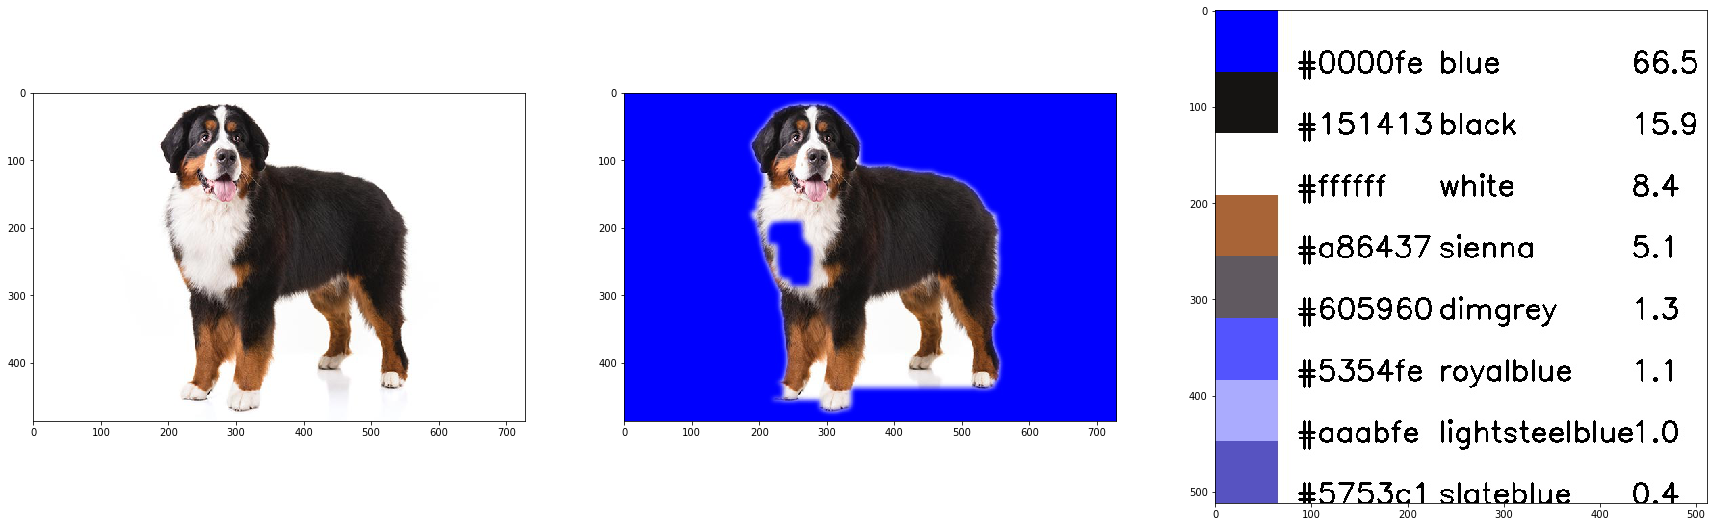

<Figure size 432x288 with 0 Axes>

In [75]:
berneseMountainDog = plt.imread("../Single Dogs/Bernese Mountain Dog Side.jpg")
masked = plt.imread("masked.jpg")
chart = plt.imread("Colour_Chart.jpg")

plt.figure(1,figsize=(30, 30))
plt.subplot(131)
plt.imshow(berneseMountainDog)
plt.subplot(132)
plt.imshow(masked)
plt.subplot(133)
plt.imshow(chart)
plt.show()
plt.savefig("Colour extraction.jpg", dpi=fig.dpi)